In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.python.methods import graphical_rica
from src.python.methods import cross_moment, cross_moment_sensor_fusion, tyc20
from src.python.generate_data import generate_data, generate_data_misspecification
from src.python.utils import save_torch_data

In [3]:
RUN_MATLAB = True

## Relative error vs sample size

### Graph: $\mathcal{G}_1$

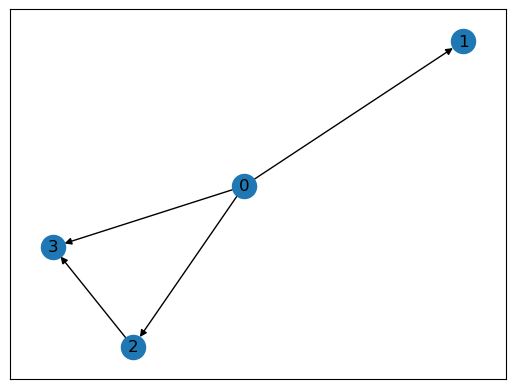

In [4]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)


In [5]:
latent = 1 
observed = 3 
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
distr_name="Laplace"
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

deg = 3
w_id = 3

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None
n_weights = len(list(g.edges))

In [6]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5

    data_stored, adj, weights = generate_data(g, observed, latent, weights, mode, max_samples, 
                distr_name, distr_params_default, distr_params)
    
    if RUN_MATLAB:
        filename = "./data/data_stored.csv"
        save_torch_data(data_stored, filename)
        !matlab -batch "q=4;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.txt', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
    
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    weight_target_CM_raw_pred.append([])
    for i, n_samples in enumerate(samples_list):
        #GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())
        
        # Cross-Moments raw
        Z = data[:, 0].numpy()
        D = data[:, 1].numpy()
        Y = data[:, 2].numpy()
        Z -= Z.mean()
        D -= D.mean()
        Y -= Y.mean()
        weight_CM_pred = cross_moment(Z, D, Y, deg)
        weight_target_CM_raw_pred[-1].append(weight_CM_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [7]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
yerr_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)
if RUN_MATLAB:
    weight_target_rica_pred = np.array(weight_target_rica_pred)

In [8]:
for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()
    yerr_CM_raw[i] = estimates.std()

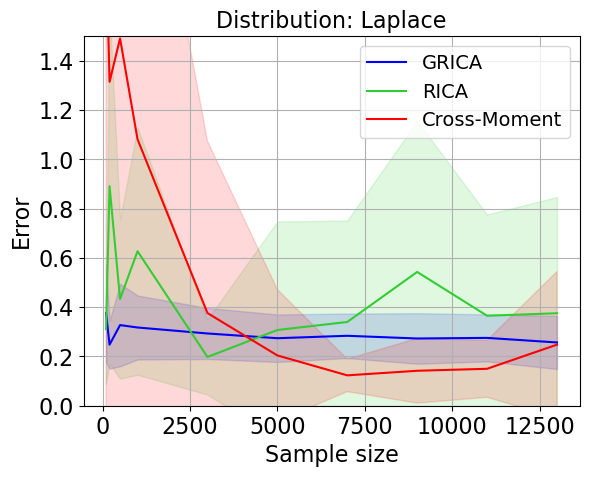

In [9]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")
plt.fill_between(x, y_CM_raw - yerr_CM_raw, y_CM_raw + yerr_CM_raw, alpha=0.15, color="red")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.savefig(f"../Figures/Estimation/{distr_name}_G1_samples_vs_err.png", bbox_inches="tight")
plt.show()

### Graph: $\mathcal{G}_2$

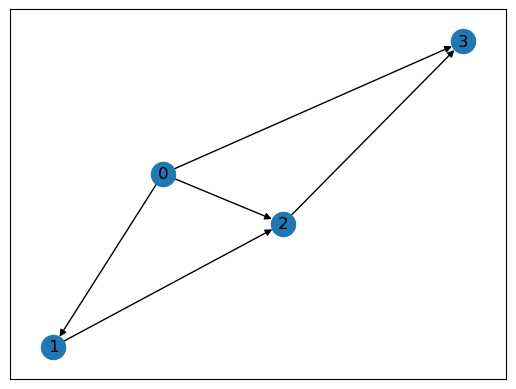

In [10]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [11]:
latent = 1 
observed = 3 
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
distr_name='Laplace'
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

deg = 3

w_id = 4

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None
n_weights = len(list(g.edges))

In [12]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5
    
    data_stored, adj, weights = generate_data(g, observed, latent, weights, mode, max_samples, 
            distr_name, distr_params_default, distr_params)
    if RUN_MATLAB:
        filename = "./data/data_stored.csv"
        save_torch_data(data_stored, filename)
        !matlab -batch "q=4;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.csv', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
        
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    weight_target_CM_raw_pred.append([])
    for i, n_samples in enumerate(samples_list):
        # GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())

        # Cross-Moments raw
        Z = data[:, 0].numpy()
        D = data[:, 1].numpy()
        Y = data[:, 2].numpy()
        Z -= Z.mean()
        D -= D.mean()
        Y -= Y.mean()
        weight_CM_pred = cross_moment(Z, D, Y, deg)
        weight_target_CM_raw_pred[-1].append(weight_CM_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [13]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
yerr_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)

In [14]:
for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()
    yerr_CM_raw[i] = estimates.std()

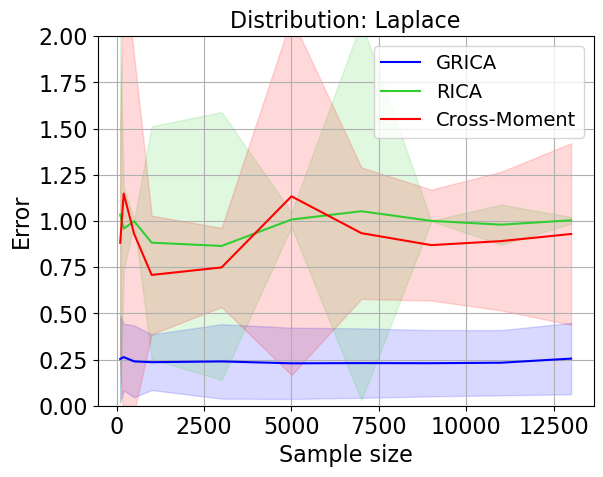

In [15]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")
plt.fill_between(x, y_CM_raw - yerr_CM_raw, y_CM_raw + yerr_CM_raw, alpha=0.15, color="red")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 2)
plt.savefig(f"../Figures/Estimation/{distr_name}_G2_samples_vs_err.png", bbox_inches="tight")
plt.show()

### Graph: $\mathcal{G}_4$

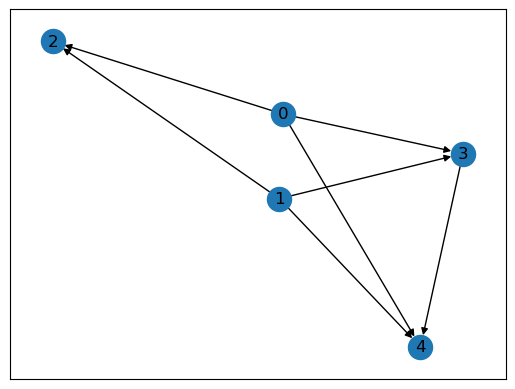

In [16]:
iv_adj = np.array([[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [17]:
latent = 2 
observed = 3 
iv_adj = np.array([[0, 0, 1, 1, 1], [0, 0, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
weights=None
distr_name='Laplace'
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

deg = 3

w_id = 6

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2022
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None
n_weights = len(list(g.edges))

In [18]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5
    
    data_stored, adj, weights = generate_data(g, observed, latent, weights, mode, max_samples, 
            distr_name, distr_params_default, distr_params)
    if RUN_MATLAB:
        filename = "./data/data_stored.csv"
        save_torch_data(data_stored, filename)
        !matlab -batch "q=5;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.csv', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
        
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    weight_target_CM_raw_pred.append([])
    for i, n_samples in enumerate(samples_list):
        # GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())

        # Cross-Moments raw
        Z = data[:, 0].numpy()
        D = data[:, 1].numpy()
        Y = data[:, 2].numpy()
        Z -= Z.mean()
        D -= D.mean()
        Y -= Y.mean()
        weight_CM_pred = cross_moment(Z, D, Y, deg)
        weight_target_CM_raw_pred[-1].append(weight_CM_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [19]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
yerr_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)

In [20]:
for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()
    yerr_CM_raw[i] = estimates.std()

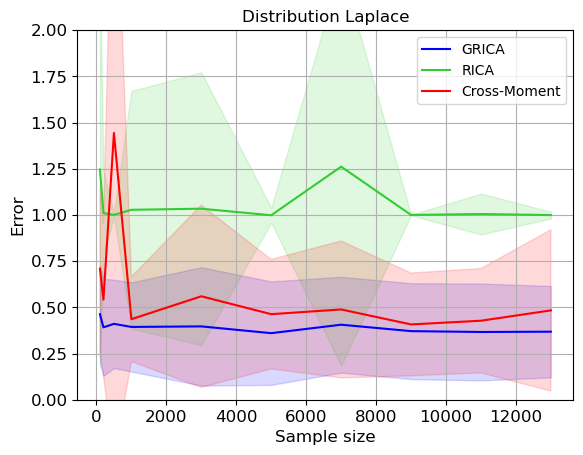

In [21]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title("Distribution Laplace")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")
plt.fill_between(x, y_CM_raw - yerr_CM_raw, y_CM_raw + yerr_CM_raw, alpha=0.15, color="red")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 2)
plt.savefig(f"../Figures/Estimation/{distr_name}_G4_samples_vs_err.png", bbox_inches="tight")
plt.show()

## Misspecification

### Graph: $\mathcal{G}_1$

In [22]:
latent = 1 
observed = 3 
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
weights_lin = {3: [(2, 3)]}
transform = torch.tanh
distr_name='Laplace'
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

deg = 3

In [23]:
w_id = 3

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None
n_weights = len(list(g.edges))

In [24]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5
    
    data_stored, adj, weights = generate_data_misspecification(g, observed, latent, weights_lin=weights_lin, mode=mode,
                                                           weights=weights, n_samples=max_samples, transform=transform,
                                                           distr_name=distr_name, distr_params_default=distr_params_default, distr_params=distr_params)
    if RUN_MATLAB:
        filename = "./data/data_stored.csv"
        save_torch_data(data_stored, filename)
        !matlab -batch "q=4;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.csv', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
    
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    weight_target_CM_raw_pred.append([])
    for i, n_samples in enumerate(samples_list):
        # GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())

        # Cross-Moments raw
        Z = data[:, 0].numpy()
        D = data[:, 1].numpy()
        Y = data[:, 2].numpy()
        Z -= Z.mean()
        D -= D.mean()
        Y -= Y.mean()
        weight_CM_pred = cross_moment(Z, D, Y, deg)
        weight_target_CM_raw_pred[-1].append(weight_CM_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [25]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
yerr_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)

In [26]:
for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()
    yerr_CM_raw[i] = estimates.std()

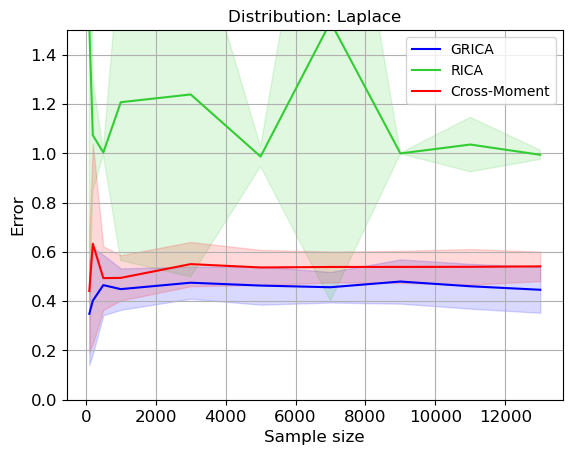

In [27]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          
plt.rc('axes', titlesize=BIGGER_SIZE)     
plt.rc('axes', labelsize=BIGGER_SIZE)    
plt.rc('xtick', labelsize=BIGGER_SIZE)    
plt.rc('ytick', labelsize=BIGGER_SIZE)    
plt.rc('legend', fontsize=MEDIUM_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)  

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")
plt.fill_between(x, y_CM_raw - yerr_CM_raw, y_CM_raw + yerr_CM_raw, alpha=0.15, color="red")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.savefig(f"../Figures/Estimation/{distr_name}_G1_samples_vs_err_misspecification.png", bbox_inches="tight")
plt.show()

### Graph: $\mathcal{G}_2$

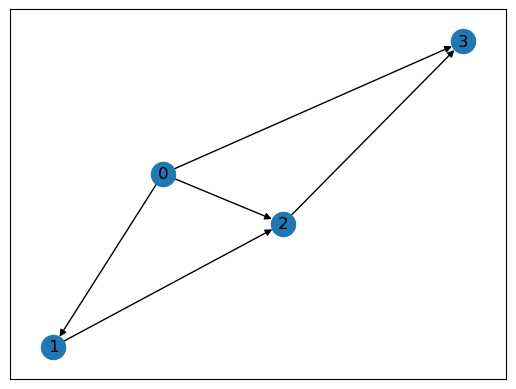

In [28]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [29]:
latent = 1 
observed = 3 
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
weights_lin = {3: [(2, 3)]}
transform = torch.tanh
distr_name='Laplace'
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

deg = 3

w_id = 4

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
distr_params = None
n_weights = len(list(g.edges))

In [30]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5
    
    data_stored, adj, weights = generate_data_misspecification(g, observed, latent, weights_lin=weights_lin, mode=mode,
                                                            weights=weights, n_samples=max_samples, transform=transform,
                                                            distr_name=distr_name, distr_params_default=distr_params_default, distr_params=distr_params)
    if RUN_MATLAB:
        filename = "./data/data_stored.csv"
        save_torch_data(data_stored, filename)
        !matlab -batch "q=4;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.csv', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
    
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    weight_target_CM_raw_pred.append([])
    for i, n_samples in enumerate(samples_list):
        # GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda=lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())

        # Cross-Moments raw
        Z = data[:, 0].numpy()
        D = data[:, 1].numpy()
        Y = data[:, 2].numpy()
        Z -= Z.mean()
        D -= D.mean()
        Y -= Y.mean()
        weight_CM_pred = cross_moment(Z, D, Y, deg)
        weight_target_CM_raw_pred[-1].append(weight_CM_pred)


Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [31]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
yerr_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)

In [32]:
for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()
    yerr_CM_raw[i] = estimates.std()

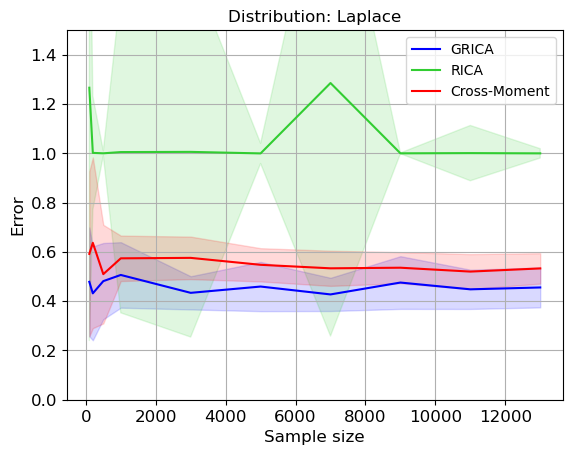

In [33]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")
plt.fill_between(x, y_CM_raw - yerr_CM_raw, y_CM_raw + yerr_CM_raw, alpha=0.15, color="red")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.savefig(f"../Figures/Estimation/{distr_name}_G2_samples_vs_err_misspecification.png", bbox_inches="tight")
plt.show()

## Cross-Moment: Noise ratio

### Cross-Moment settings

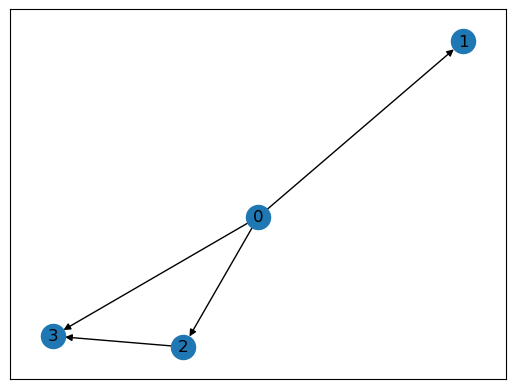

In [34]:
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [35]:
latent = 1 
observed = 3 
iv_adj = np.array([[0, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
distr_name="Laplace"
distr_params_default=False
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 500

deg = 3

w_id = 3

n_samples = 5000

snr_rates = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10]

In [36]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []

weight_target_true.append([])
weight_target_GRICA_pred.append([])
weight_target_rica_pred.append([])
weight_target_CM_raw_pred.append([])
file_name = "./data/out.txt"
seed = 2024
for i, snr_rate in enumerate(snr_rates):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    u_params = {"loc": 0, "scale": 1}
    z_params = {"loc": 0, "scale": 1*snr_rate}
    d_params = {"loc": 0, "scale": 1}
    y_params = {"loc": 0, "scale": 1*snr_rate}
    distr_params=[u_params, z_params, d_params, y_params]

    alpha_z, alpha_d, gamma, beta = -1, -1, -1, -1
    weights = torch.Tensor([alpha_z, alpha_d, gamma, beta])

    data, adj, weights = generate_data(g, observed, latent, weights,
                                            mode, n_samples, distr_name, 
                                            distr_params_default, distr_params)
    if RUN_MATLAB:    
        filename = "./data/data.csv"
        save_torch_data(data, filename)
        
        !matlab -batch "q=4;run('./src/matlab/main_noise_ratio.m');"
        with open(file_name, 'r') as file:
            weight_pred = file.read()
            weight_pred = float(weight_pred)
            weight_target_rica_pred[-1].append(weight_pred)

    # GRICA
    d_cov = (data.t()).cov()
    
    # Whitening 
    U, S, V = d_cov.svd()
    S_2=torch.inverse(torch.diag(S.sqrt()))
    W_w = S_2.matmul(V.t())
    data_whitened = W_w.matmul(data.t()).t()
    w_true = weights
    loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
    weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
    weight_target_true[-1].append(weight_true[w_id].detach().item())

    # Cross-Moment
    Z = data[:, 0].numpy()
    D = data[:, 1].numpy()
    Y = data[:, 2].numpy()
    Z -= Z.mean()
    D -= D.mean()
    Y -= Y.mean()
    weight_CM_pred = cross_moment(Z, D, Y, deg)
    weight_target_CM_raw_pred[-1].append(weight_CM_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [37]:
# Preprocess data to make a plot
x = snr_rates
y_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)

In [38]:
for i, snr_rate in enumerate(snr_rates):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()

    # Cross-Moment
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()

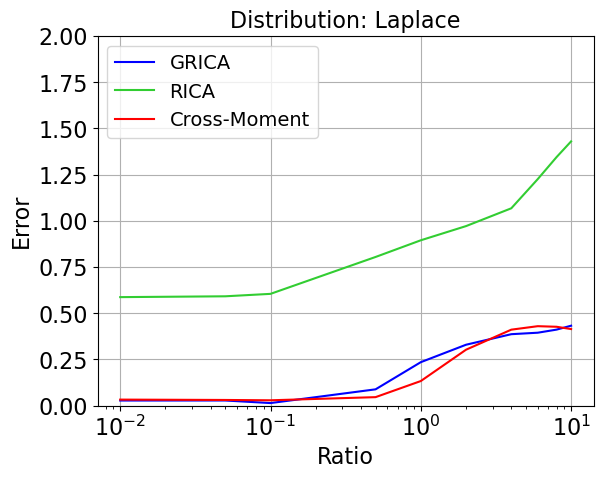

In [39]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Ratio")
plt.ylabel("Error")
plt.xscale("log")
plt.plot(x, y_GRICA, label="GRICA", color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")

plt.legend(loc="upper left")
plt.grid()
plt.ylim(0, 2)
plt.savefig(f"../Figures/Estimation/{distr_name}_G1_snr_vs_err.png", bbox_inches="tight")
plt.show()

### Two proxy graph

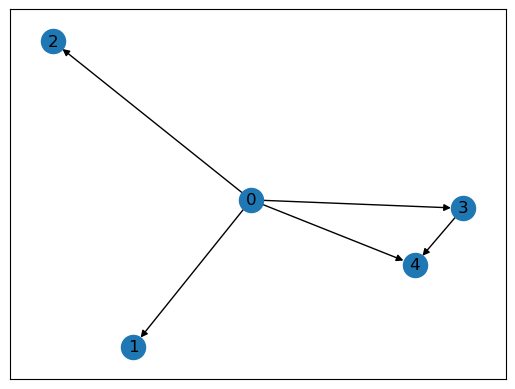

In [40]:
iv_adj = np.array([[0, 1, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [41]:
latent = 1 
observed = 4 
iv_adj = np.array([[0, 1, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]])
g = nx.DiGraph(iv_adj)
distr_name="Laplace"
distr_params_default=False
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 500

deg = 3

w_id = 4

n_samples = 5000

snr_rates = [1, 2, 4, 6, 8, 10, 20, 100]

In [42]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []
weight_target_CM_raw_pred = []
weight_target_tyc20_pred = []

weight_target_true.append([])
weight_target_GRICA_pred.append([])
weight_target_rica_pred.append([])
weight_target_CM_raw_pred.append([])
weight_target_tyc20_pred.append([])
file_name = "./data/out.txt"
seed = 2024
for i, snr_rate in enumerate(snr_rates):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    u_params = {"loc": 0, "scale": 1}
    z1_params = {"loc": 0, "scale": 1*snr_rate}
    z2_params = {"loc": 0, "scale": 1/snr_rate}
    d_params = {"loc": 0, "scale": 1}
    y_params = {"loc": 0, "scale": 1}
    distr_params=[u_params, z1_params, z2_params, d_params, y_params]

    alpha_z1, alpha_z2, alpha_d, gamma, beta = 1, 1, 1, 1, 1
    weights = torch.Tensor([alpha_z1, alpha_z2, alpha_d, gamma, beta])

    data, adj, weights = generate_data(g, observed, latent, weights,
                                                                 mode, n_samples, distr_name,
                                                                 distr_params_default, distr_params)
    if RUN_MATLAB:
        filename = "./data/data.csv"
        save_torch_data(data, filename)

        !matlab -batch "q=5;run('./src/matlab/main_noise_ratio.m');"
        with open(file_name, 'r') as file:
            weight_pred = file.read()
            weight_pred = float(weight_pred)
            weight_target_rica_pred[-1].append(weight_pred)
    
    # GRICA
    d_cov = (data.t()).cov()
    
    # Whitening 
    U, S, V = d_cov.svd()
    S_2=torch.inverse(torch.diag(S.sqrt()))
    W_w = S_2.matmul(V.t())
    data_whitened = W_w.matmul(data.t()).t()
    w_true = weights
    loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
    weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
    weight_target_true[-1].append(weight_true[w_id].detach().item())
    
    
    # Cross-Moments W-Z
    Z1 = data[:, 0].numpy()
    Z2 = data[:, 1].numpy()
    D = data[:, 2].numpy()
    Y = data[:, 3].numpy()
    Z1 -= Z1.mean()
    Z2 -= Z2.mean()
    D -= D.mean()
    Y -= Y.mean()
    weight_CM_pred = cross_moment_sensor_fusion(Z1, Z2, D, Y, deg)
    weight_target_CM_raw_pred[-1].append(weight_CM_pred)

    # TYC-20
    Z1 = data[:, 0].numpy()
    Z2 = data[:, 1].numpy()
    D = data[:, 2].numpy()
    Y = data[:, 3].numpy()
    weight_tyc20_pred = tyc20(Z1, Z2, D, Y)
    weight_target_tyc20_pred[-1].append(weight_tyc20_pred)

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [43]:
# Preprocess data to make a plot
x = snr_rates
y_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
y_CM_raw = np.zeros(len(x))
y_tyc20 = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)
weight_target_CM_raw_pred = np.array(weight_target_CM_raw_pred)
weight_target_tyc20_pred = np.array(weight_target_tyc20_pred)

In [44]:
for i, snr_scale in enumerate(snr_rates):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()

    #RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()

    # Cross-Moment W-Z
    estimates = np.abs((weight_target_CM_raw_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_CM_raw[i] = estimates.mean()

    # TYC20
    estimates = np.abs((weight_target_tyc20_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_tyc20[i] = estimates.mean()

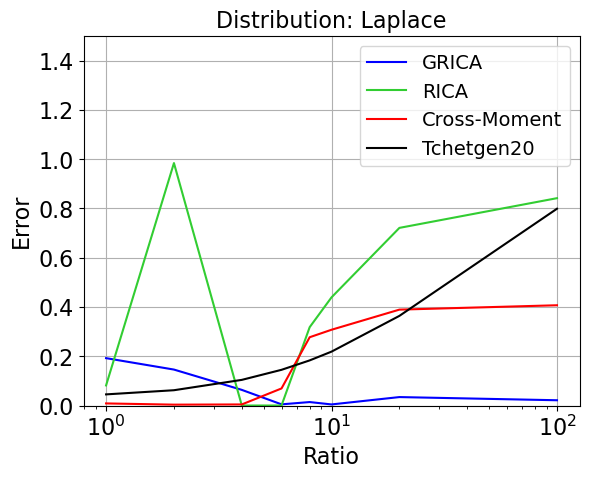

In [45]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Ratio")
plt.ylabel("Error")
plt.xscale("log")

plt.plot(x, y_GRICA, label="GRICA", color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")

plt.plot(x, y_CM_raw, label="Cross-Moment", color="red")

plt.plot(x, y_tyc20, label="Tchetgen20", color="black")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 1.5)
plt.savefig(f"../Figures/Estimation/{distr_name}_G3_snr_vs_err.png", bbox_inches="tight")
plt.show()

## IV Estimation

### Sample size vs Error

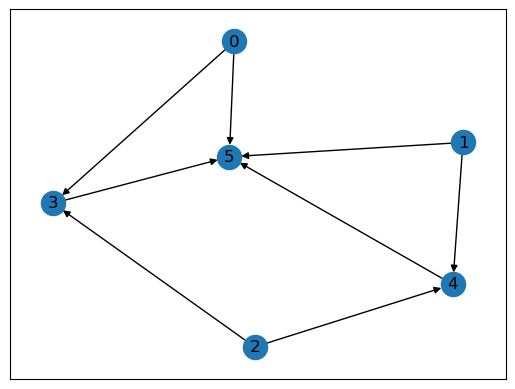

In [46]:
iv_adj = np.array([[0,0,0,1,0,1],
                      [0,0,0,0,1,1],
                      [0,0,0,1,1,0],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [47]:
latent = 2
observed = 4
iv_adj = np.array([[0,0,0,1,0,1],
                      [0,0,0,0,1,1],
                      [0,0,0,1,1,0],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0]])
g = nx.DiGraph(iv_adj)
distr_name="Laplace"
distr_params_default=True
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 400

w_id = 5

max_samples = 15000
min_samples = 1000
step_size = 2000
samples_list = [100, 200, 500] + list(range(min_samples, max_samples, step_size))
pd_samples_list = pd.DataFrame(samples_list)
filename = "./data/sample_list.csv"
pd_samples_list.to_csv(filename, index=False, header=False)

seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

distr_params = None
n_weights = len(list(g.edges))

In [48]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []

n_trials = 10
for trial in range(n_trials):
    weights = torch.Tensor(n_weights).uniform_(-0.5, 0.5)
    for i in range(n_weights):
        if weights[i]>0:
            weights[i] += 0.5
        else:
            weights[i] -= 0.5

    data_stored, adj, weights = generate_data(g, observed, latent, weights, mode, max_samples, 
                distr_name, distr_params_default, distr_params)
    filename = "./data/data_stored.csv"
    if RUN_MATLAB:
        save_torch_data(data_stored, filename)
        !matlab -batch "q=6;run('./src/matlab/main.m');"
        weights_pred = np.genfromtxt('./data/pred.txt', delimiter=',')
        weights_pred = list(weights_pred)
        weight_target_rica_pred.append(weights_pred)
    
    weight_target_true.append([])
    weight_target_GRICA_pred.append([])
    for i, n_samples in enumerate(samples_list):
        #GRICA
        data = data_stored[:n_samples]
        d_cov = (data.t()).cov()
        
        # Whitening 
        U, S, V = d_cov.svd()
        S_2=torch.inverse(torch.diag(S.sqrt()))
        W_w = S_2.matmul(V.t())
        data_whitened = W_w.matmul(data.t()).t()
        w_true = weights
        loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
        weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
        weight_target_true[-1].append(weight_true[w_id].detach().item())

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [49]:
# Preprocess data to make a plot
x = samples_list
y_GRICA = np.zeros(len(x))
yerr_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))
yerr_rica = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)

for i, n_samples in enumerate(samples_list):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()
    yerr_GRICA[i] = estimates.std()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()
        yerr_rica[i] = estimates.std()

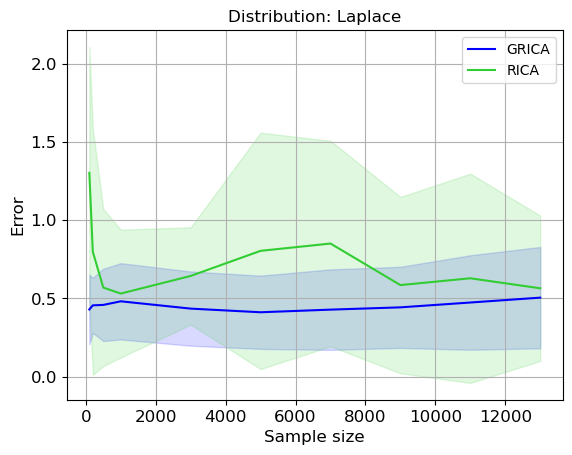

In [50]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Sample size")
plt.ylabel("Error")

plt.plot(x, y_GRICA, label="GRICA", color="blue")
plt.fill_between(x, y_GRICA - yerr_GRICA, y_GRICA + yerr_GRICA, alpha=0.15, color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")
    plt.fill_between(x, y_rica - yerr_rica, y_rica + yerr_rica, alpha=0.15, color="limegreen")

plt.legend(loc="upper right")
plt.grid()
plt.savefig(f"../Figures/Estimation/{distr_name}_iv_samples_vs_err.png", bbox_inches="tight")
plt.show()

### Noise ratio vs Error

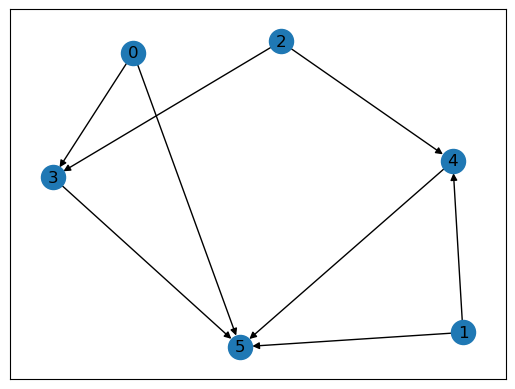

In [51]:
iv_adj = np.array([[0,0,0,1,0,1],
                      [0,0,0,0,1,1],
                      [0,0,0,1,1,0],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0]])
g = nx.DiGraph(iv_adj)
nx.draw_networkx(g)

In [52]:
latent = 2
observed = 4
iv_adj = np.array([[0,0,0,1,0,1],
                      [0,0,0,0,1,1],
                      [0,0,0,1,1,0],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,1],
                      [0,0,0,0,0,0]])
g = nx.DiGraph(iv_adj)
distr_name="Laplace"
distr_params_default=False
mode = None

lr = 0.1
w_init = 'cov_guess'
lmbda_GRICA = 0
momentum = 0
epochs = 500

deg = 3

w_id = 5

n_samples = 5000

snr_rates = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10]

In [53]:
weight_target_true = []
weight_target_GRICA_pred = []
weight_target_rica_pred = []

weight_target_true.append([])
weight_target_GRICA_pred.append([])
weight_target_rica_pred.append([])
file_name = "./data/out.txt"
seed = 2023
for i, snr_rate in enumerate(snr_rates):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    u1_params = {"loc": 0, "scale": 1*snr_rate}
    u2_params = {"loc": 0, "scale": 1*snr_rate}
    z_params = {"loc": 0, "scale": 1}
    x1_params = {"loc": 0, "scale": 1}
    x2_params = {"loc": 0, "scale": 1}
    y_params = {"loc": 0, "scale": 1}
    distr_params=[u1_params, u2_params, z_params, x1_params, x2_params, y_params]

    u1x1, u1y, u2x2, u2y, zx1, zx2, x1y, x2y = 1, 1, 1, 1, 1, 1, 1, 1
    weights = torch.Tensor([u1x1, u1y, u2x2, u2y, zx1, zx2, x1y, x2y])

    data, adj, weights = generate_data(g, observed, latent, weights,
                                            mode, n_samples, distr_name, 
                                            distr_params_default, distr_params)
    if RUN_MATLAB:
        filename = "./data/data.csv"
        save_torch_data(data, filename)
        
        !matlab -batch "q=6;run('./src/matlab/main_noise_ratio.m');"
        with open(file_name, 'r') as file:
            weight_pred = file.read()
            weight_pred = float(weight_pred)
            weight_target_rica_pred[-1].append(weight_pred)

    # GRICA
    d_cov = (data.t()).cov()
    
    # Whitening 
    U, S, V = d_cov.svd()
    S_2=torch.inverse(torch.diag(S.sqrt()))
    W_w = S_2.matmul(V.t())
    data_whitened = W_w.matmul(data.t()).t()
    w_true = weights
    loss_data, w_loss_data, weight_pred, weight_true = graphical_rica(latent, observed, g, data, data_whitened, epochs, lr, W_w, w_init, w_true, momentum, lmbda_GRICA)
    weight_target_GRICA_pred[-1].append(weight_pred[w_id].detach().item())
    weight_target_true[-1].append(weight_true[w_id].detach().item())

Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully
Rica finished successfully


In [54]:
# Preprocess data to make a plot
x = snr_rates
y_GRICA = np.zeros(len(x))
y_rica = np.zeros(len(x))

weight_target_true = np.array(weight_target_true)
weight_target_GRICA_pred = np.array(weight_target_GRICA_pred)
weight_target_rica_pred = np.array(weight_target_rica_pred)

In [55]:
for i, snr_rate in enumerate(snr_rates):
    # GRICA
    estimates = np.abs((weight_target_GRICA_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
    y_GRICA[i] = estimates.mean()

    # RICA
    if RUN_MATLAB:
        estimates = np.abs((weight_target_rica_pred[:, i] - weight_target_true[:, i]) / weight_target_true[:, i])
        y_rica[i] = estimates.mean()

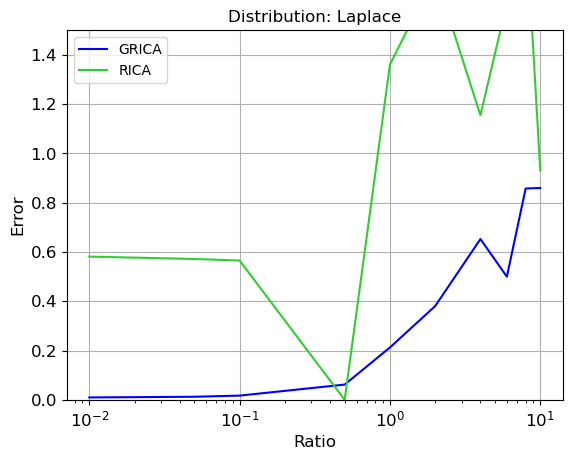

In [56]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Plot the results
plt.title(f"Distribution: {distr_name}")
plt.xlabel("Ratio")
plt.ylabel("Error")
plt.xscale("log")
plt.plot(x, y_GRICA, label="GRICA", color="blue")

if RUN_MATLAB:
    plt.plot(x, y_rica, label="RICA", color="limegreen")

plt.legend(loc="upper left")
plt.grid()
plt.ylim(0, 1.5)
plt.savefig(f"../Figures/Estimation/{distr_name}_iv_snr_vs_err.png", bbox_inches="tight")
plt.show()